# Regression Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gridTest import gridTest

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

from linearReg import LinearReg
from gdOptimizers import GDOptimizers

### Setup of data

In [2]:
def franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
def data(n = 100):
    x = np.random.rand(n) #an array of n unordered uniform random numbers from 0 to 1
    y = np.random.rand(n)
    xy = np.column_stack((x, y))
    
    noise = np.random.randn(n) / 10
    z = np.array([franke(x, y) + noise]).T
    return xy, z

In [4]:
xy, z = data(100)
xy_train, xy_test, z_train, z_test = train_test_split(xy, z, test_size = 0.2)

### FFNN

In [5]:
from FFNN import FFNN

nn = FFNN(inputs = 2)
nn.addLayer(neurons = 5, activation = "sigmoid")
nn.addLayer(neurons = 1, activation = "linear")

sgd = GDOptimizers(learning_rate = 0.00005, epochs = 1000, batch_size = 10, optimizer = "momentum")
nn.compile(loss="mse", optimizer=sgd, lmda = 0.01)

In [6]:
z_mdl = nn.predict(xy_test)
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")
z_mdl = nn.predict(xy_train)
print(f"Mean squared error on training data = {mean_squared_error(z_mdl, z_train):.4f}")

nn.fit(xy_train, z_train)
z_train_mdl = nn.predict(xy_train)
z_mdl = nn.predict(xy_test)

print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error = 3.8282
Mean squared error on training data = 3.4758
Mean squared error on training data = 0.1171
Mean squared error = 0.1807


In [7]:
def createNN(eta, lmda, params):
    nn = FFNN(inputs = params["inputs"])
    for nrons, activation in zip(params["neurons"], params["activations"]):
        nn.addLayer(neurons = nrons, activation = activation)

    sgd = GDOptimizers(learning_rate = eta, epochs = 100, batch_size = 10, optimizer = "SGD")
    nn.compile(loss="mse", optimizer=sgd, lmda = lmda)
    return nn

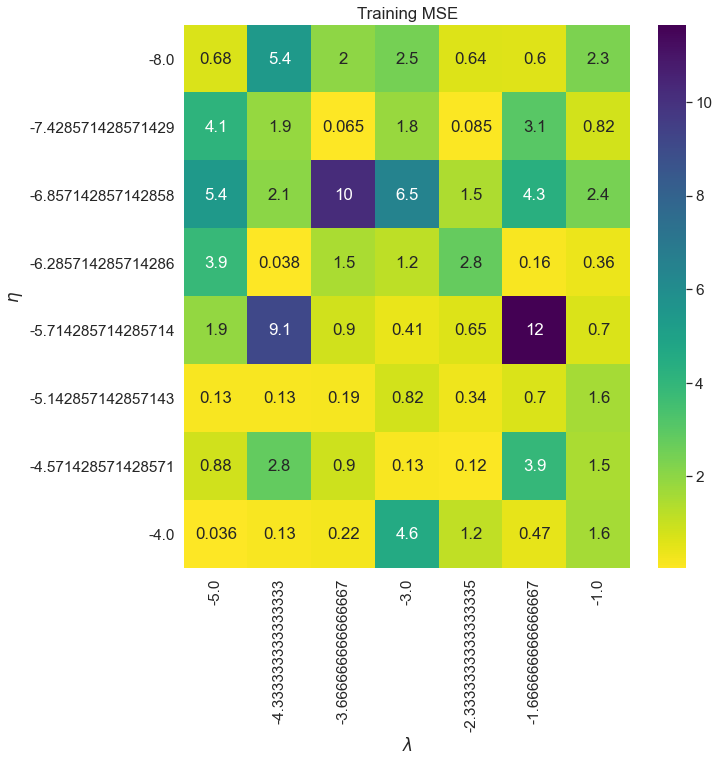

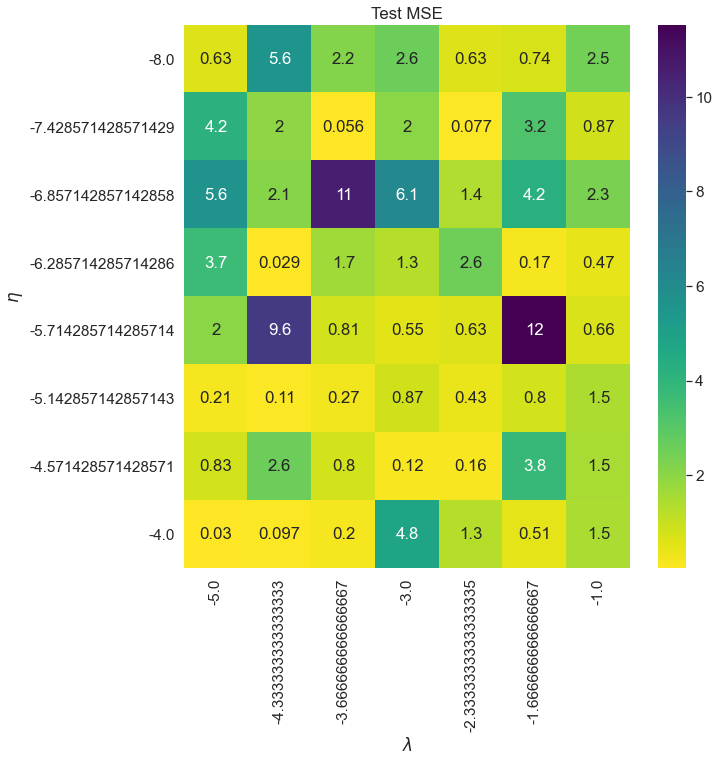

In [10]:
etas = np.logspace(-8, -4, 8)
lmdas = np.logspace(-5, -1, 7)

params = {"inputs": 2, "neurons":[5,1], "activations":["sigmoid", "linear"]}
gridTest(etas, lmdas, createNN, params, 'mse', xy_train, xy_test, z_train, z_test)

### Ridge regression with SGD

In [15]:
sgd = GDOptimizers(learning_rate = 0.01, epochs = 1000, batch_size = 10, optimizer = "SGD")
model = LinearReg(order = 3, lmda = 1E-5, sgd = sgd)
z_mdl = model.predict(xy_test)
print(f"Mean squared error before fit = {mean_squared_error(z_mdl, z_test):.4f}")

z_train_mdl = model.fit(xy_train, z_train)

z_mdl = model.predict(xy_test)
print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error before fit = 0.7544


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [16]:
momentum = GDOptimizers(learning_rate = 0.01, epochs = 1000, batch_size = 10, optimizer = "momentum", alpha=0.5)
model = LinearReg(order = 3, lmda = 1E-5, sgd = sgd)

model.fit(xy_train, z_train)
z_train_mdl = model.predict(xy_train)
z_mdl = model.predict(xy_test)
print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error on training data = 0.0158
Mean squared error = 0.0184


In [17]:
def createRidge(eta, lmda, params):
    sgd = GDOptimizers(learning_rate = eta, epochs = 1000, batch_size = 10, optimizer = "SGD")
    model = LinearReg(order = params["order"], lmda = lmda, sgd = sgd)
    return model

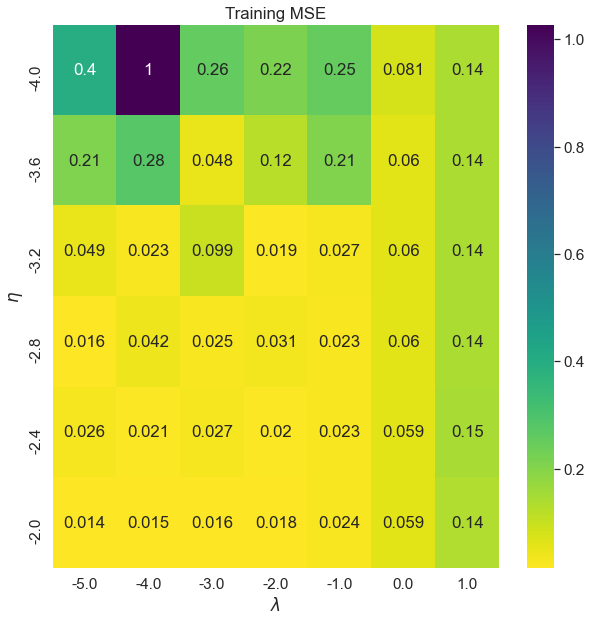

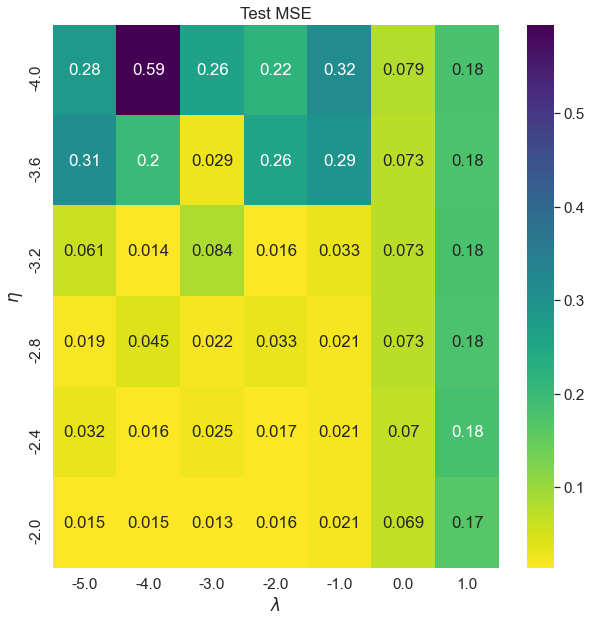

In [18]:
etas = np.logspace(-4, -2, 6)
lmdas = np.logspace(-5, 1, 7)

params = {"order": 3}
gridTest(etas, lmdas, createRidge, params, 'mse', xy_train, xy_test, z_train, z_test)

### Regression with Tensorflow

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function

from sklearn.model_selection import train_test_split

In [ ]:
model = Sequential()
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1))

eta = 0.001
sgd = optimizers.SGD(lr=eta)
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])

z_mdl = model.predict(xy_test)
print(f"Mean squared error before fit = {mean_squared_error(z_mdl, z_test):.4f}")

model.fit(xy_train, z_train, epochs=1000, batch_size=10, verbose=0)
#scores = model.evaluate(xy_test, z_test)

z_mdl = model.predict(xy_test)
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")